## 資料集 and 一些參數設定

1. import需要的東西
2. 將data set分成traing /testing data
3. 將數據轉換為 PyTorch 張量
4. 設定一些必要參數



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Boston Housing dataset
data = fetch_california_housing()

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(data.data)
y = data.target.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# 設定參數
D_in = X.shape[1]
H = 11
D_out = 1

# learning rate
learning_rate = 0.1

# when step size < 0.001, stop training => Unacceptable
threshold = 0.001

## 1. weight-tuning_EB ====> regularizing_EB


*   EB(epoch bound) = 100



In [ ]:
# Define 2-layer neural network
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Tanh(),
    torch.nn.Linear(H, D_out)
)

# 定義優化器和損失函數
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []


for epoch in range(100):
  optimizer.zero_grad()
  output = model(X_train)
  loss = criterion(output, y_train) # Loss(w)
  loss.backward() # 對w的偏微分得到方向
  optimizer.step() # w往偏微分的方向走一個step size

  # Collect the training loss values in list
  train_losses.append(loss.item())


  if epoch % 10 == 0:
    print('Epoch {}/100, Loss: {:.4f}'.format(epoch, loss.item()))

epsilon = loss.item()
print('\nepsilon = ', epsilon)

Epoch 0/100, Loss: 5.9917
Epoch 10/100, Loss: 0.7625
Epoch 20/100, Loss: 0.5876
Epoch 30/100, Loss: 0.5192
Epoch 40/100, Loss: 0.4826
Epoch 50/100, Loss: 0.4593
Epoch 60/100, Loss: 0.4410
Epoch 70/100, Loss: 0.4256
Epoch 80/100, Loss: 0.4121
Epoch 90/100, Loss: 0.4021

epsilon =  0.3948827087879181


In [ ]:
torch.save(model, 'Acc_EB.pt') # 存下 weight-tuning_EB 的 Acceptable SLFN

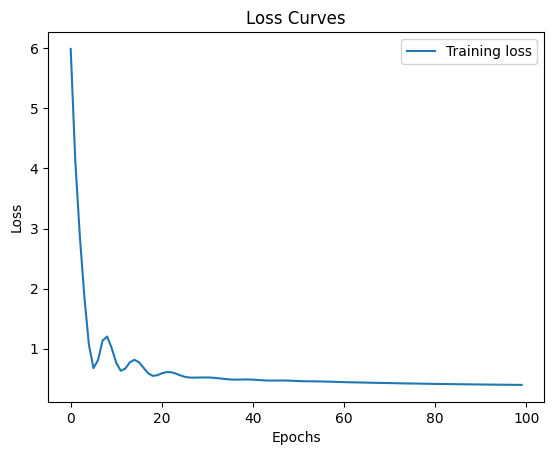

Test Loss: 0.42215093970298767


In [ ]:
# Plot the loss curves
plt.plot(range(len(train_losses)), train_losses, label='Training loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the network
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss: {}'.format(test_loss.item()))

In [ ]:
# load Acc_EB.pt
model_reg_EB = torch.load('Acc_EB.pt')

# 定義優化器和損失函數
criterion = nn.MSELoss()
# L2 regulization
optimizer = optim.Adam(model_reg_EB.parameters(), lr=learning_rate, weight_decay=0.01)

train_losses = []

model_reg_EB.train() # 啟用訓練模式

for epoch in range(100):
  optimizer.zero_grad()
  output = model_reg_EB(X_train)
  loss = criterion(output, y_train) # Loss(w)
  loss.backward() # 對w的偏微分得到方向
  optimizer.step() # w往偏微分的方向走一個step size

  # Collect the training loss values in list
  train_losses.append(loss.item())


  if epoch % 10 == 0:
    print('Epoch {}/100, Loss: {:.4f}'.format(epoch, loss.item()))
print('------------------------')
if loss.item() < epsilon:
  print('Acceptable SLFN')
  torch.save(model, 'reg_EB.pt') # 存下 regularizing_EB 的 Acceptable SLFN
else:
  print('Restore w, because regularizing_EB does not get lower loss.')
  model_reg_EB = torch.load('Acc_EB.pt')

Epoch 0/100, Loss: 0.3944
Epoch 10/100, Loss: 0.4317
Epoch 20/100, Loss: 0.4202
Epoch 30/100, Loss: 0.4053
Epoch 40/100, Loss: 0.3989
Epoch 50/100, Loss: 0.4000
Epoch 60/100, Loss: 0.3989
Epoch 70/100, Loss: 0.3979
Epoch 80/100, Loss: 0.3972
Epoch 90/100, Loss: 0.3961
------------------------
Restore w, because regularizing_EB does not get lower loss.


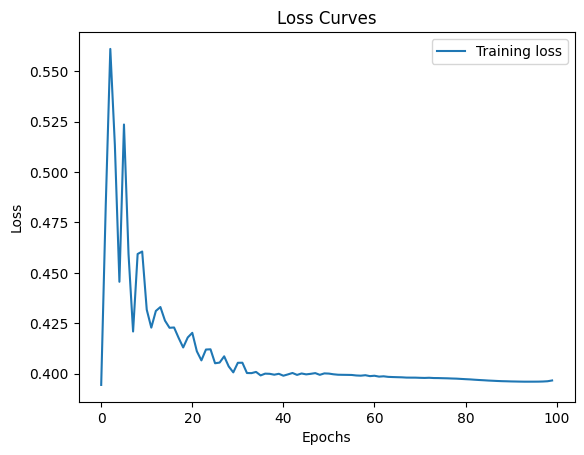

Test Loss: 0.42215093970298767


In [ ]:
# Plot the loss curves
plt.plot(range(len(train_losses)), train_losses, label='Training loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the network
model.eval()
with torch.no_grad():
    test_outputs = model_reg_EB(X_test)
    test_loss = criterion(test_outputs, y_test)
    print('Test Loss: {}'.format(test_loss.item()))

## **Evaluation**

weight-tuning_EB 已經在一個local minimum的地區，所以即使用learning rate decay使step size越來越小，仍然走不出平原區。

## 2. weight-tuning_LG_UA ====> regularizing_LG_UA


*   Learning Goal : loss要小於0.4
*   Undesired Attractor : learning rate 不能小於 0.001




In [ ]:
# Define 2-layer neural network
model_LG_UA = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Tanh(),
    torch.nn.Linear(H, D_out)
)

# 定義優化器和損失函數
criterion = nn.MSELoss()
optimizer = optim.Adam(model_LG_UA.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
# 訓練模型
b_loss = float('Inf')
epoch = 0
while b_loss > 0.4: # traing loss要小於我設定的stopping criteria才會停
  # 第一次forward
  optimizer.zero_grad()
  output_1 = model_LG_UA(X_train) # w
  torch.save(model_LG_UA.state_dict(), 'save.pt') # 存下w的參數
  w_loss = criterion(output_1, y_train) # Loss(w)
  w_loss.backward() # w的偏微分

  while optimizer.param_groups[0]['lr'] > threshold:
    # optimizer.step() => According to learning rate and other parameters，來更新我們的參數。
    optimizer.step() # w'：w往偏微分的方向走一個step size

    # 第二次forward
    output_2 = model_LG_UA(X_train) # w'
    ww_loss = criterion(output_2, y_train) # Loss(w')

    # 這裡要判斷 : Loss(w') 是否小於 Loss(w)
    if ww_loss < w_loss:
      # 目前參數：w'
      # step size變大
      optimizer.param_groups[0]['lr'] *= 1.2
      b_loss = ww_loss
      # Collect the training loss values in list
      train_losses.append(ww_loss.item())
      epoch += 1
      if epoch % 1 == 0:
        print('Epoch {}, Loss: {:.4f}'.format(epoch, b_loss))
      break
    else:
      # 此時 step size 一定大於 threshold
      # 參數要是：w
      model_LG_UA.load_state_dict(torch.load("save.pt"))
      # step size *0.7
      optimizer.param_groups[0]['lr'] *= 0.7
      b_loss = ww_loss
      # Collect the training loss values in list
      train_losses.append(ww_loss.item())
      epoch += 1
      print('Epoch {}, Loss: {:.4f} > {}'.format(epoch, b_loss, w_loss.item()))

  '''if epoch % 100 == 0:
      print('Epoch {}, Loss: {:.4f}'.format(epoch+1, b_loss))'''

  if optimizer.param_groups[0]['lr'] <= threshold:
    print('Unacceptable because learning rate too small, Epoch {}, Loss: {:.4f}, Step size: {}'.format(epoch, b_loss, optimizer.param_groups[0]['lr']))
    break

if b_loss < 0.4:
  print('\nAcceptable, Epoch {}, Loss: {}'.format(epoch, b_loss))

epsilon = b_loss.item()
print('epsilon = ', epsilon)

Epoch 1, Loss: 4.1539
Epoch 2, Loss: 2.2801
Epoch 3, Loss: 0.9925
Epoch 4, Loss: 1.0046 > 0.9925128817558289
Epoch 5, Loss: 0.4860
Epoch 6, Loss: 0.5697 > 0.48599234223365784
Epoch 7, Loss: 0.4464
Epoch 8, Loss: 0.4449
Epoch 9, Loss: 0.4342
Epoch 10, Loss: 0.5006 > 0.43419304490089417
Epoch 11, Loss: 0.4123
Epoch 12, Loss: 0.4207 > 0.4122609496116638
Epoch 13, Loss: 0.3997

Acceptable, Epoch 13, Loss: 0.39973974227905273
epsilon =  0.39973974227905273


In [ ]:
torch.save(model_LG_UA, 'Acc_LG_UA.pt') # 存下 weight-tuning_LG_UA 的 Acceptable SLFN

In [ ]:
# load Acc_LG_UA.pt
model_reg_LG_UA = torch.load('Acc_LG_UA.pt')

# 定義優化器和損失函數
criterion = nn.MSELoss()
# L2 regulization
optimizer = optim.Adam(model_reg_LG_UA.parameters(), lr=learning_rate, weight_decay=0.01)

train_losses = []
# 訓練模型
model_reg_LG_UA.train() #訓練模式
b_loss = float('Inf')
epoch = 0
while b_loss > epsilon: # training loss要小於我設定的stopping criteria才會停
  # 第一次forward
  optimizer.zero_grad()
  output_1 = model_reg_LG_UA(X_train) # w
  torch.save(model.state_dict(), 'save.pt') # 存下w的參數
  w_loss = criterion(output_1, y_train) # Loss(w)
  w_loss.backward() # w的偏微分

  while optimizer.param_groups[0]['lr'] > threshold:
    # optimizer.step() => According to learning rate and other parameters，來更新我們的參數。
    optimizer.step() # w'：w往偏微分的方向走一個step size

    # 第二次forward
    output_2 = model_reg_LG_UA(X_train) # w'
    ww_loss = criterion(output_2, y_train) # Loss(w')

    # 這裡要判斷 : Loss(w') 是否小於 Loss(w)
    if ww_loss < w_loss and ww_loss < epsilon:
      # 目前參數：w'
      # step size變大
      optimizer.param_groups[0]['lr'] *= 1.2
      b_loss = ww_loss
      # Collect the training loss values in list
      train_losses.append(ww_loss.item())
      epoch += 1
      print('Epoch {}, Loss: {:.4f}'.format(epoch, b_loss))
      break
    else:
      # 此時 step size 一定大於 threshold
      # 參數要是：w
      model_reg_LG_UA.load_state_dict(torch.load("save.pt"))
      # step size *0.7
      optimizer.param_groups[0]['lr'] *= 0.7
      b_loss = ww_loss
      # Collect the training loss values in list
      train_losses.append(ww_loss.item())
      epoch += 1
      print('Epoch {}, Loss: {:.4f} > {}'.format(epoch, b_loss, w_loss.item()))

  '''if epoch % 100 == 0:
      print('Epoch {}, Loss: {:.4f}'.format(epoch+1, b_loss))'''

  if optimizer.param_groups[0]['lr'] <= threshold:
    print('\nRestore w because learning rate too small, Epoch {}, Loss: {:.4f}, Step size: {}'.format(epoch+1, b_loss, optimizer.param_groups[0]['lr']))
    model_reg_LG_UA = torch.load('save.pt')
    break

if b_loss < epsilon:
  print('\nStore new w, Epoch {}, Loss: {}'.format(epoch, b_loss))

Epoch 1, Loss: 0.4836 > 0.3943721652030945
Epoch 2, Loss: 0.4391 > 0.3943721652030945
Epoch 3, Loss: 0.4162 > 0.3943721652030945
Epoch 4, Loss: 0.4047 > 0.3943721652030945
Epoch 5, Loss: 0.3989 > 0.3943721652030945
Epoch 6, Loss: 0.3961 > 0.3943721652030945
Epoch 7, Loss: 0.3948 > 0.3943721652030945
Epoch 8, Loss: 0.3943

Store new w, Epoch 8, Loss: 0.394305944442749


## **Evaluation**
使用learning rate decay使step size越來越小，regularizing_LG_UA 得到更小的loss。

## 3. weight-tuning_EB_LG_UA ====> regularizing_EB_LG_UA

*   Epoch Bound : 100
*   Learning Goal : loss要小於0.4
*   Undesired Attractor : learning rate 不能小於 0.001


In [ ]:
# Define 2-layer neural network
model_EB_LG_UA = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Tanh(),
    torch.nn.Linear(H, D_out)
)

# 定義優化器和損失函數
criterion = nn.MSELoss()
optimizer = optim.Adam(model_EB_LG_UA.parameters(), lr=learning_rate)

In [ ]:
bound = 100
train_losses = []
# 訓練模型
b_loss = float('Inf')
for epoch in range(bound):
  while b_loss > 0.4:
    # 第一次forward
    optimizer.zero_grad()
    output_1 = model_EB_LG_UA(X_train) # w
    torch.save(model_EB_LG_UA.state_dict(), 'save.pt') # 存下w的參數
    w_loss = criterion(output_1, y_train) # Loss(w)
    w_loss.backward() # w的偏微分

    while optimizer.param_groups[0]['lr'] > threshold:
      # optimizer.step() => According to learning rate and other parameters，來更新我們的參數。
      optimizer.step() # w'：w往偏微分的方向走一個step size

      # 第二次forward
      output_2 = model_EB_LG_UA(X_train) # w'
      ww_loss = criterion(output_2, y_train) # Loss(w')

      # 這裡要判斷 : Loss(w') 是否小於 Loss(w)
      if ww_loss < w_loss:
        # 目前參數：w'
        # step size變大
        optimizer.param_groups[0]['lr'] *= 1.2
        b_loss = ww_loss
        # Collect the training loss values in list
        train_losses.append(ww_loss.item())
        epoch += 1
        '''print('Epoch {}, Loss: {:.4f}'.format(epoch, b_loss))'''
        break
      else:
        # 此時 step size 一定大於 threshold
        # 參數要是：w
        model_EB_LG_UA.load_state_dict(torch.load("save.pt"))
        # step size *0.7
        optimizer.param_groups[0]['lr'] *= 0.7
        b_loss = ww_loss
        # Collect the training loss values in list
        train_losses.append(ww_loss.item())
        epoch += 1
        # print('Epoch {}, Loss: {:.4f} > {}'.format(epoch, b_loss, w_loss.item()))

    '''if epoch % 100 == 0:
        print('Epoch {}, Loss: {:.4f}'.format(epoch+1, b_loss))'''

    if optimizer.param_groups[0]['lr'] <= threshold:
      print('Unacceptable because learning rate too small, Epoch {}, Loss: {:.4f}, Step size: {}'.format(epoch, b_loss, optimizer.param_groups[0]['lr']))
      break

  if b_loss < 0.4 and optimizer.param_groups[0]['lr'] > threshold and epoch < bound:
    print('Acceptable,early stop, Epoch {}, Loss: {}'.format(epoch, b_loss))
    break
  else:
    break

if epoch >= bound:
  print('Unacceptable because epoch greater than bound, Epoch {}, Loss: {:.4f}, Step size: {}'.format(epoch, b_loss, optimizer.param_groups[0]['lr']))


Acceptable,early stop, Epoch 67, Loss: 0.39931273460388184


In [ ]:
torch.save(model_EB_LG_UA, 'Acc_EB_LG_UA.pt') # 存下 weight-tuning_EB_LG_UA 的 Acceptable SLFN

In [ ]:
epsilon = b_loss.item()
print('epsilon = ', epsilon)

epsilon =  0.39931273460388184


In [ ]:
# load Acc_EB_LG_UA.pt
model_reg_EB_LG_UA = torch.load('Acc_EB_LG_UA.pt')

# 定義優化器和損失函數
criterion = nn.MSELoss()
# L2 regulization
optimizer = optim.Adam(model_reg_EB_LG_UA.parameters(), lr=learning_rate, weight_decay=0.01)


bound = 100
train_losses = []
# 訓練模型
model_reg_EB_LG_UA.train()
b_loss = float('Inf')
for epoch in range(bound):
  while b_loss > epsilon:
    # 第一次forward
    optimizer.zero_grad()
    output_1 = model_reg_EB_LG_UA(X_train) # w
    torch.save(model_reg_EB_LG_UA.state_dict(), 'save.pt') # 存下w的參數
    w_loss = criterion(output_1, y_train) # Loss(w)
    w_loss.backward() # w的偏微分

    while optimizer.param_groups[0]['lr'] > threshold:
      # optimizer.step() => According to learning rate and other parameters，來更新我們的參數。
      optimizer.step() # w'：w往偏微分的方向走一個step size

      # 第二次forward
      output_2 = model_reg_EB_LG_UA(X_train) # w'
      ww_loss = criterion(output_2, y_train) # Loss(w')

      # 這裡要判斷 : Loss(w') 是否小於 Loss(w)
      if ww_loss < w_loss and w_loss < epsilon:
        # 目前參數：w'
        # step size變大
        optimizer.param_groups[0]['lr'] *= 1.2
        b_loss = ww_loss
        # Collect the training loss values in list
        train_losses.append(ww_loss.item())
        epoch += 1
        print('Epoch {}, Loss: {:.4f}'.format(epoch, b_loss))
        break
      else:
        # 此時 step size 一定大於 threshold
        # 參數要是：w
        model_reg_EB_LG_UA.load_state_dict(torch.load("save.pt"))
        # step size *0.7
        optimizer.param_groups[0]['lr'] *= 0.7
        b_loss = ww_loss
        # Collect the training loss values in list
        train_losses.append(ww_loss.item())
        epoch += 1
        print('Epoch {}, Loss: {:.4f} > {}'.format(epoch, b_loss, w_loss.item()))

    '''if epoch % 100 == 0:
        print('Epoch {}, Loss: {:.4f}'.format(epoch+1, b_loss))'''

    if optimizer.param_groups[0]['lr'] <= threshold:
      print('Restore w because learning rate too small, Epoch {}, Loss: {:.4f}, Step size: {}'.format(epoch, b_loss, optimizer.param_groups[0]['lr']))
      model_reg_EB_LG_UA = torch.load('save.pt')
      break

  if b_loss < epsilon and optimizer.param_groups[0]['lr'] > threshold and epoch < bound:
    print('\nAcceptable,early stop, Epoch {}, Loss: {}'.format(epoch, b_loss))
    break
  else:
    break

if epoch >= bound:
  print('Unacceptable because epoch greater than bound, Epoch {}, Loss: {:.4f}, Step size: {}'.format(epoch, b_loss, optimizer.param_groups[0]['lr']))


Epoch 1, Loss: 0.4836 > 0.3943721652030945
Epoch 2, Loss: 0.4391 > 0.3943721652030945
Epoch 3, Loss: 0.4162 > 0.3943721652030945
Epoch 4, Loss: 0.4047 > 0.3943721652030945
Epoch 5, Loss: 0.3989 > 0.3943721652030945
Epoch 6, Loss: 0.3961 > 0.3943721652030945
Epoch 7, Loss: 0.3948 > 0.3943721652030945
Epoch 8, Loss: 0.3943

Acceptable,early stop, Epoch 8, Loss: 0.394305944442749


## **Evaluation**
使用learning rate decay使step size越來越小，regularizing_EB_LG_UA 得到更小的loss。

## 4. weight-tuning_EB ====> weight-tuning_DO ====> regularizing_DO




*   Epoch bound = 100
*   Drop Out 的機率：0.5




In [ ]:
# Define 2-layer neural network
model_DO = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(H, D_out)
)

# 定義優化器和損失函數
criterion = nn.MSELoss()
optimizer = optim.Adam(model_DO.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(100):
  optimizer.zero_grad()
  output = model_DO(X_train)
  torch.save(model_DO.state_dict(), 'save.pt') # 存下w的參數
  loss = criterion(output, y_train) # Loss(w)
  loss.backward() # 對w的偏微分得到方向
  optimizer.step() # w往偏微分的方向走一個step size

  # Collect the training loss values in list
  train_losses.append(loss.item())


  if epoch % 10 == 0:
    print('Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))

print('-----------------------------------')
print('Finish: Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))
epsilon = loss.item()
print('epsilon set to {}'.format(loss.item()))

Epoch 1/100, Loss: 7.3837
Epoch 11/100, Loss: 1.6040
Epoch 21/100, Loss: 0.9153
Epoch 31/100, Loss: 0.7621
Epoch 41/100, Loss: 0.6930
Epoch 51/100, Loss: 0.6523
Epoch 61/100, Loss: 0.6260
Epoch 71/100, Loss: 0.5910
Epoch 81/100, Loss: 0.5894
Epoch 91/100, Loss: 0.5692
-----------------------------------
Finish: Epoch 100/100, Loss: 0.5691
epsilon set to 0.5690639019012451


In [ ]:
torch.save(model_DO, 'Acc_DO.pt') # 存下 weight-tuning_DO 的 Acceptable SLFN

In [ ]:
# load Acc_DO.pt
model_reg_DO = torch.load('Acc_DO.pt')

# 定義優化器和損失函數
criterion = nn.MSELoss()
# L2 regulization
optimizer = optim.Adam(model_reg_DO.parameters(), lr=learning_rate, weight_decay=0.01)


train_losses = []
model_reg_DO.train()
for epoch in range(100):
  optimizer.zero_grad()
  output = model_DO(X_train)
  loss = criterion(output, y_train) # Loss(w)
  loss.backward() # 對w的偏微分得到方向
  optimizer.step() # w往偏微分的方向走一個step size

  # Collect the training loss values in list
  train_losses.append(loss.item())


  if epoch % 10 == 0:
    print('Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))

if loss.item() < epsilon:
  print('Acceptable')
else:
  print('\nRestore w because regularizing_DO does not get smaller loss')
  model_reg_DO = torch.load('Acc_DO.pt')
print('Finish: Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))

Epoch 1/100, Loss: 0.5602
Epoch 11/100, Loss: 0.5657
Epoch 21/100, Loss: 0.5664
Epoch 31/100, Loss: 0.5647
Epoch 41/100, Loss: 0.5584
Epoch 51/100, Loss: 0.5644
Epoch 61/100, Loss: 0.5682
Epoch 71/100, Loss: 0.5596
Epoch 81/100, Loss: 0.5640
Epoch 91/100, Loss: 0.5692
Acceptable
Finish: Epoch 100/100, Loss: 0.5626


## **Evaluation**
weight-tuning_DO用weight decay再訓練100次，使loss到一個更低的地方。

## 5. weight-tuning_EB ====> weight-tuning_BN ====> regularizing_BN

*   Epoch bound = 100

In [ ]:
# Define 2-layer neural network
model_BN = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.BatchNorm1d(H),
    torch.nn.Tanh(),
    torch.nn.Linear(H, D_out)
)

# 定義優化器和損失函數
criterion = nn.MSELoss()
optimizer = optim.Adam(model_BN.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(100):
  optimizer.zero_grad()
  output = model_BN(X_train)
  loss = criterion(output, y_train) # Loss(w)
  loss.backward() # 對w的偏微分得到方向
  optimizer.step() # w往偏微分的方向走一個step size

  # Collect the training loss values in list
  train_losses.append(loss.item())


  if epoch % 10 == 0:
    print('Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))

print('-----------------------------------')
print('Finish: Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))
epsilon = loss.item()
print('epsilon set to {}'.format(loss.item()))

Epoch 1/100, Loss: 5.9962
Epoch 11/100, Loss: 0.7425
Epoch 21/100, Loss: 0.5936
Epoch 31/100, Loss: 0.5395
Epoch 41/100, Loss: 0.4830
Epoch 51/100, Loss: 0.4502
Epoch 61/100, Loss: 0.4327
Epoch 71/100, Loss: 0.4167
Epoch 81/100, Loss: 0.4021
Epoch 91/100, Loss: 0.3893
-----------------------------------
Finish: Epoch 100/100, Loss: 0.3785
epsilon set to 0.37852543592453003


In [ ]:
torch.save(model_BN, 'Acc_BN.pt') # 存下 weight-tuning_BN 的 Acceptable SLFN

In [ ]:
# load Acc_DO.pt
model_reg_BN = torch.load('Acc_BN.pt') # w

# 定義優化器和損失函數
criterion = nn.MSELoss()
# L2 regulization
optimizer = optim.Adam(model_reg_BN.parameters(), lr=learning_rate, weight_decay=0.01)


train_losses = []
model_reg_BN.train()
for epoch in range(100):
  optimizer.zero_grad()
  output = model_reg_BN(X_train)
  loss = criterion(output, y_train) # Loss(w)
  loss.backward() # 對w的偏微分得到方向
  optimizer.step() # w往偏微分的方向走一個step size

  # Collect the training loss values in list
  train_losses.append(loss.item())


  if epoch % 10 == 0:
    print('Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))

if loss.item() < epsilon:
  print('Acceptable')
else:
  print('\nRestore w because regularizing_BN does not get smaller loss')
  model_reg_BN = torch.load('Acc_BN.pt')
print('Finish: Epoch {}/100, Loss: {:.4f}'.format(epoch+1, loss.item()))

Epoch 1/100, Loss: 0.3944
Epoch 11/100, Loss: 0.4317
Epoch 21/100, Loss: 0.4202
Epoch 31/100, Loss: 0.4053
Epoch 41/100, Loss: 0.3989
Epoch 51/100, Loss: 0.4000
Epoch 61/100, Loss: 0.3989
Epoch 71/100, Loss: 0.3979
Epoch 81/100, Loss: 0.3972
Epoch 91/100, Loss: 0.3961

Restore w because regularizing_BN does not get smaller loss
Finish: Epoch 100/100, Loss: 0.3966


## **Evaluation**
即使對weight-tuning_BN用weight decay再訓練100次，仍然沒有辦法使loss再更低，原因可能是因為weight-tuning_BN 已經到達local minimum了。

其中weight-tuning_BN可以得到所有模型中最小的loss。